In [1]:
import os,glob,sys,re,json,joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import hydroeval as he
from pathlib import Path, PosixPath
from typing import Dict, List, Tuple
from sklearn.model_selection import cross_val_predict, train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
import pickle
import shap
from datetime import datetime
from tqdm import tqdm
import argparse
from src.utils import check_GPU, LogTrans, InvLogTrans, aleplot_1D_continuous, pdpplot_1D_continuous, undersample
import multiprocessing as mp
import statsmodels.api as sm

def load_data(cfg,  resample = False):
    # read dataset
    df = pd.read_pickle(cfg['fname'])

    # shuffle data 
    if resample:
        df = df.sample(frac=1, random_state = cfg['seed']).reset_index(drop=True)

    # # limit to those catchments with at least 0.1% changes in the urban area over the study period (1982-2023)
    # tmp = df.groupby('ohdb_id').ImperviousSurface.apply(lambda x:x.max()-x.min()).reset_index()
    # df = df.loc[df.ohdb_id.isin(tmp.loc[tmp.ImperviousSurface>=0.1,'ohdb_id'].values),:]
    # print(df.ohdb_id.unique().shape)

    # # assign weights to the inverse of length of records
    # num_records = df.groupby('ohdb_id')['Q'].count().reset_index().rename(columns={'Q':'weight'})
    # num_records['weight'] = 1 / num_records['weight']
    # df = df.merge(num_records, on = 'ohdb_id')

    # limit gauges to those with minimal influences of dams:
        # 2. percentage of reservoir area to catchment area less than 10
    # from pyogrio import read_dataframe
    # import geopandas as gpd
    # df_attr = pd.read_csv('../data/basin_attributes_new.csv')
    # gdf_dam = read_dataframe('../../data/geography/GDAT_data_v1/data/GDAT_v1_dams.shp').to_crs('epsg:8857')
    # gdf_res = read_dataframe('../../data/geography/GDAT_data_v1/data/GDAT_v1_catchments.shp').to_crs('epsg:8857')
    # gdf_res['RESarea'] = gdf_res.area / 1000000
    # gdf_dam = gdf_dam.merge(gdf_res[['Feature_ID','RESarea']], on = 'Feature_ID')
    # gdf_basin = read_dataframe('../basin_boundary/GRIT_full_catchment_all_EPSG8857_simplify_final_125km2_subset.gpkg')
    # connect = gpd.sjoin(gdf_dam[['Feature_ID','RESarea','geometry']], gdf_basin, how = 'right', predicate = 'within').dropna()
    # connect = connect.groupby('ohdb_id').apply(lambda x: pd.Series([
    #         x.Feature_ID.count(),
    #         x.RESarea.sum(),
    #         x.gritDarea.sum()
    #     ], index = ['countD','RESarea','gritDarea']),
    #     # include_groups=False,
    # ).fillna(0).reset_index()
    # connect['ratio'] = connect.RESarea / connect.gritDarea * 100
    # connect.to_csv('../data/basin_reservoir_darea_ratio.csv', index = False)
    # connect = pd.read_csv('../data/basin_reservoir_darea_ratio.csv')
    # connect = connect.loc[(connect.ratio>=10),:]
    # df = df.loc[~df.ohdb_id.isin(connect.ohdb_id),:].reset_index(drop=True)

    # # limit gauges to those with positive STD of urban area
    # df1 = df.groupby(['ohdb_id','year']).ImperviousSurface.apply(lambda x:x.iloc[0]).reset_index()
    # df1 = df1.groupby('ohdb_id').ImperviousSurface.std()
    # df1 = df1.loc[df1>0]
    # df = df.loc[df.ohdb_id.isin(df1.index.values),:].reset_index(drop=True)

    # # limit to upstream gauges
    # gdf = pd.read_csv('../basin_boundary/GRIT_full_catchment_all_EPSG8857_simplify_final_125km2_subset_onlyUpstream.csv')
    # df = df.loc[df.ohdb_id.isin(gdf.ohdb_id.values),:].reset_index(drop=True)

    # # limit to 1993-2012 to make a 20-year balanced panel data for DynamicDML
    # df = df.loc[(df.year>=1993)&(df.year<=2012),:]
    # df1 = df.groupby('ohdb_id')['year'].count().reset_index()
    # df = df.loc[df.ohdb_id.isin(df1.loc[df1.year==20,'ohdb_id'].values),:]

    # predictand
    y = df['Q'].astype(np.float32).values
    if cfg['log'] == True and cfg['m3s'] == True:
        raise Exception('log and m3s cannot be both True')
    elif cfg['log'] == True and cfg['m3s'] == False:
        y = LogTrans(y, darea = df['gritDarea'].values, addition = 0.1, log = True)
    elif cfg['log'] == False and cfg['m3s'] == False:
        y = y

    # predictors
    predictors = cfg['meteo_name'] + cfg['lulc_name'] + cfg['attr_name']
    cfg['predictors'] = predictors
    X = df[predictors].astype(np.float32)

    # get feature dtype
    cate_attr = []
    feature_types = X.agg(lambda x: 'q').to_dict()
    for a in ['climate', 'season_id', 'Main_Purpose_id', 'basin_id', 'gauge_id', 'koppen_id', 'year']:
        if a in predictors:
            cate_attr.append(a)
            feature_types[a] = 'c'
            X[a] = X[a].astype(np.int16)
    feature_types = list(feature_types.values())
    cfg['feature_types'] = feature_types
    cfg['categorical_attr'] = cate_attr

    # transfrom from numpy array to cupy array for GPU modeling
    if cfg['gpu']:
        X = cp.array(X)

    return df, X, y, cfg

# check if GPU is available
GPU = check_GPU()
if GPU:
    import cupy as cp

with open('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/cfg.json','rb') as f:
    cfg = json.load(f)

cfg['run_dir'] = Path(cfg['run_dir'])
model = cfg['model']
mode = cfg['mode']
predictors = cfg['meteo_name'] + cfg['lulc_name'] + cfg['attr_name']
GPU = cfg['gpu']
run_dir = cfg['run_dir']
model = cfg['model']
log = cfg['log']
m3s = cfg['m3s']
cfg['gpu'] = True

# load data
df, X, y, cfg = load_data(cfg)
df['obs'] = y
df['obs_nolog'] = np.exp(y)

/home/cenv1021/.conda/envs/xgb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
for mode in ['noLULC','onlyUrban']:
    if mode == 'noLULC':
        s = [item for item in predictors if item not in ['ImperviousSurface', 'forest', 'crop', 'grass', 'water', 'wetland']]
    elif mode == 'onlyUrban':
        s = [item for item in predictors if item not in ['forest', 'crop', 'grass', 'water', 'wetland']]
    X = df[s].astype(np.float32).values
    ml = pickle.load(open(cfg["run_dir"] / f'{model}_{mode}_model.pkl','rb'))
    param_dict = ml.get_params()
    param_dict['device'] = 'gpu'
    ml = xgb.XGBRegressor(**param_dict)

    seed = 1234
    cv = KFold(n_splits = 5, shuffle = True, random_state = seed)
    out = np.zeros(df.shape[0])
    for train_index, test_index in tqdm(cv.split(X)):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        if GPU:
            X_train = cp.array(X_train)
            X_test = cp.array(X_test)
        ml.fit(X_train, y_train)
        y_pred0 = ml.predict(X_test)
        out[test_index] = y_pred0
    y_pred = np.array(out)
    y_pred_nolog = np.exp(y_pred)
    y_pred_origin = InvLogTrans(y_pred, darea = df['gritDarea'].values, log = log)
    y_pred_origin = np.where(y_pred_origin < 0, 0, y_pred_origin)  

    df['pred_'+mode] = y_pred
    df['pred_nolog_'+mode] = y_pred_nolog
    df['pred_origin_'+mode] = y_pred_origin



it [02:00, 24.19s/it]

In [7]:
df1 = df.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','aridity','climate_label']).apply(
    lambda x:pd.Series(
        he.kge(x.pred_noLULC.values, x.obs.values).squeeze().tolist() + 
        he.kge(x.pred_onlyUrban.values, x.obs.values).squeeze().tolist() + 
        he.kge(x.pred_origin_noLULC.values, x.Q.values).squeeze().tolist() + 
        he.kge(x.pred_origin_onlyUrban.values, x.Q.values).squeeze().tolist() + 
        he.kge(x.pred_nolog_noLULC.values, x.obs_nolog.values).squeeze().tolist() + 
        he.kge(x.pred_nolog_onlyUrban.values, x.obs_nolog.values).squeeze().tolist(),
        index = [
            a+'_noLULC' for a in ['KGE','r','alpha','beta']] + [
            a+'_onlyUrban' for a in ['KGE','r','alpha','beta']] + [
            a+'_noLULC_origin' for a in ['KGE','r','alpha','beta']] + [
            a+'_onlyUrban_origin' for a in ['KGE','r','alpha','beta']] + [
            a+'_noLULC_nolog' for a in ['KGE','r','alpha','beta']
        ] + [
            a+'_onlyUrban_nolog' for a in ['KGE','r','alpha','beta']
        ]
    )
).reset_index()

/tmp/ipykernel_1216762/3268159141.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','aridity','climate_label']).apply(


In [8]:
df1

,ohdb_id,ohdb_longitude,ohdb_latitude,aridity,climate_label,KGE_noLULC,r_noLULC,alpha_noLULC,beta_noLULC,KGE_onlyUrban,...,alpha_onlyUrban_origin,beta_onlyUrban_origin,KGE_noLULC_nolog,r_noLULC_nolog,alpha_noLULC_nolog,beta_noLULC_nolog,KGE_onlyUrban_nolog,r_onlyUrban_nolog,alpha_onlyUrban_nolog,beta_onlyUrban_nolog
0,OHDB_001000004,-67.595000,1.074000,2.586089,tropical,0.648388,0.674574,0.868166,0.981328,0.659558,...,0.800945,0.955398,0.639704,0.700161,0.807590,0.946261,0.669195,0.739578,0.800945,0.955400
1,OHDB_001000006,-69.126000,0.477000,2.307032,tropical,0.783902,0.858288,0.836855,1.000153,0.795342,...,0.832717,0.982739,0.778631,0.855153,0.833527,0.982391,0.791079,0.876038,0.832717,0.982739
2,OHDB_001000008,-69.786000,0.248000,2.606057,tropical,0.562035,0.585879,0.857465,1.000964,0.565502,...,0.670312,0.964582,0.462624,0.569901,0.678588,0.978025,0.487014,0.608583,0.670312,0.964597
3,OHDB_001000023,-63.288000,-9.759000,1.617943,tropical,0.836480,0.906466,0.867498,0.979179,0.852987,...,0.831919,0.904641,0.761838,0.884724,0.815199,0.903662,0.776527,0.887616,0.831919,0.904823
4,OHDB_001000030,-59.465000,-10.170000,1.426788,tropical,0.897781,0.946521,0.912975,0.996070,0.907578,...,0.913888,0.966000,0.866592,0.938499,0.890382,0.955285,0.890151,0.940873,0.913888,0.966006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8613,OHDB_016000316,110.104538,32.831529,0.784082,temperate,0.852728,0.901438,0.891129,0.988971,0.840282,...,0.717300,0.894997,0.660483,0.865778,0.708397,0.889439,0.672299,0.871765,0.717300,0.895001
8614,OHDB_016000330,111.509002,32.510972,0.769127,temperate,0.757364,0.782385,0.893325,0.988327,0.723215,...,0.614860,0.866648,0.643918,0.839730,0.702163,0.888642,0.573842,0.875515,0.614860,0.866653
8615,OHDB_016000347,111.482652,28.900168,1.192250,temperate,0.867128,0.932029,0.885856,0.997563,0.873005,...,0.813627,0.916142,0.799674,0.913981,0.834577,0.926744,0.783411,0.928279,0.813627,0.916143
8616,OHDB_016000351,107.748738,29.319895,1.095607,temperate,0.873371,0.906463,0.932354,1.052055,0.850798,...,0.895889,1.001714,0.878269,0.914182,0.914794,1.013914,0.849262,0.891004,0.895889,1.001714


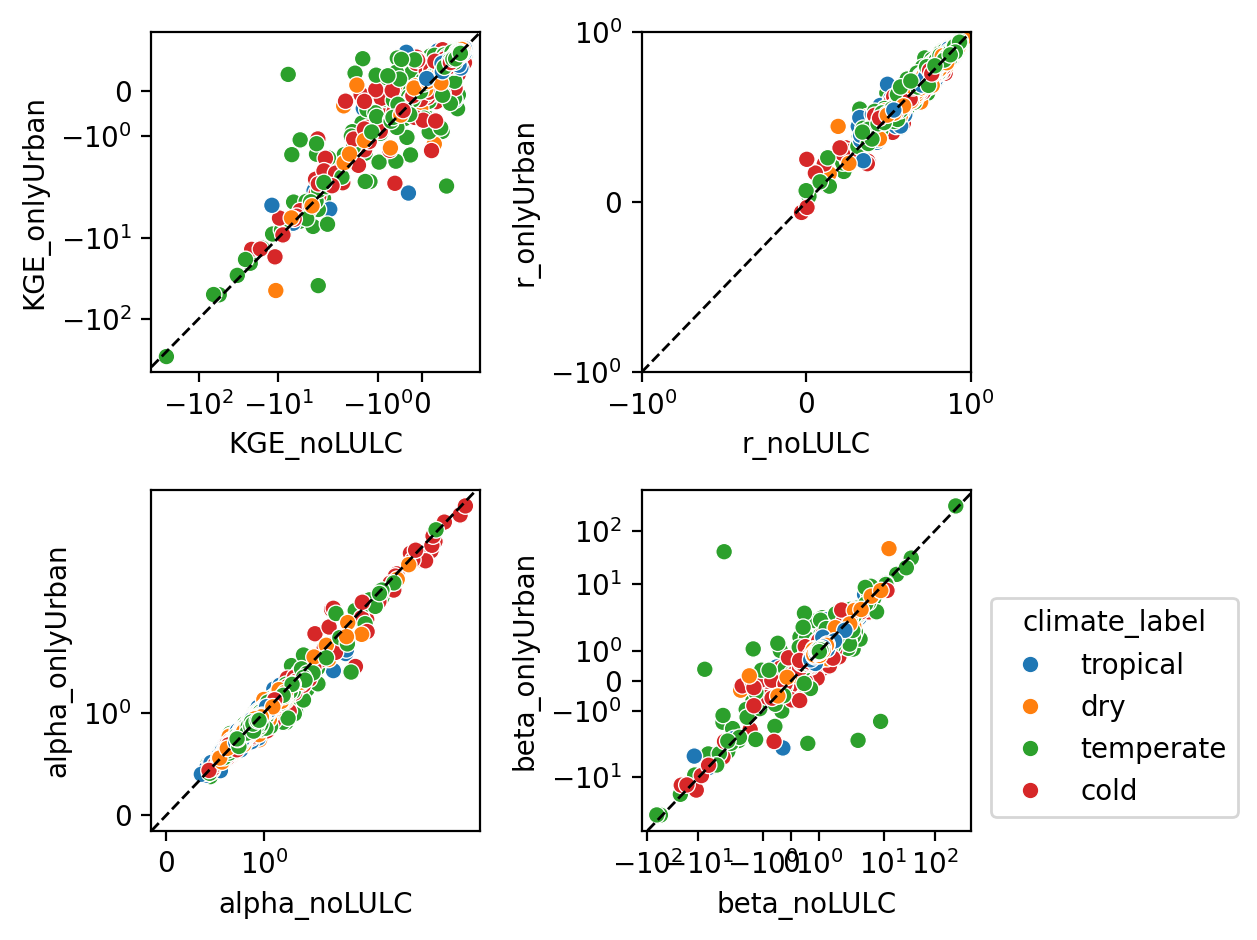

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, dpi=200)
for i,name in enumerate(['KGE','r','alpha','beta']):
    ax = axes.ravel()[i]
    x = name + '_noLULC'
    y = name + '_onlyUrban'
    if i == 3:
        sns.scatterplot(df1.reset_index(), x = x, y = y, hue = 'climate_label', ax = ax)
        sns.move_legend(ax, 'lower left', bbox_to_anchor = (1.02, 0))
    else:
        sns.scatterplot(df1.reset_index(), x = x, y = y, hue = 'climate_label', ax = ax, legend = False)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    if i == 1:
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
    ax.axline(xy1 = (0, 0), xy2 = (0.5, 0.5), lw = 1, c = 'k', ls = 'dashed')
fig.tight_layout()

<Axes: xlabel='diff', ylabel='Density'>

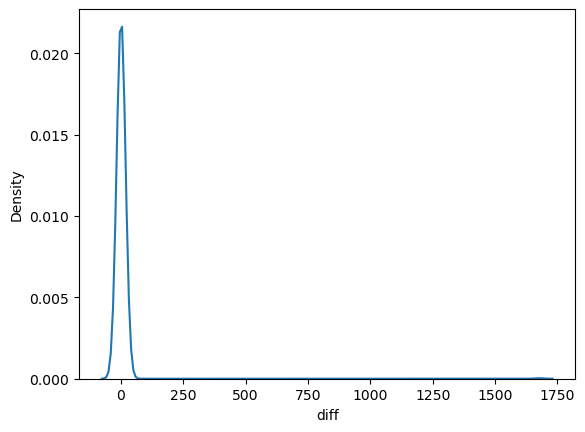

In [24]:
sns.kdeplot(df1.loc[df1.climate_label=='dry',:], x = 'diff')